# 1 - Risk and return models


In this section, we compare how well the different risk models predict an out-of-sample covariance matrix, and how well the different returns models predict out-of-sample returns.

## Risk models

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, expected_returns, plotting
pypfopt.__version__

'1.5.5'

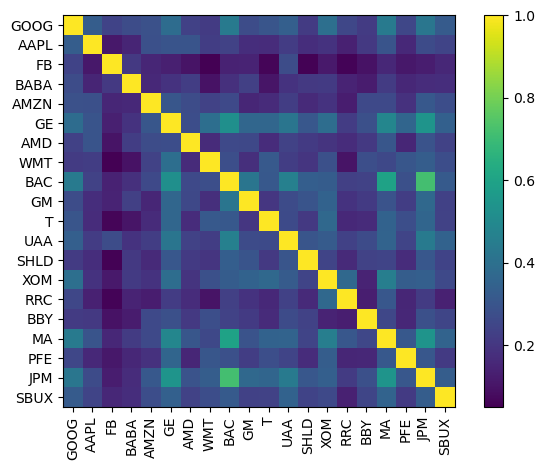

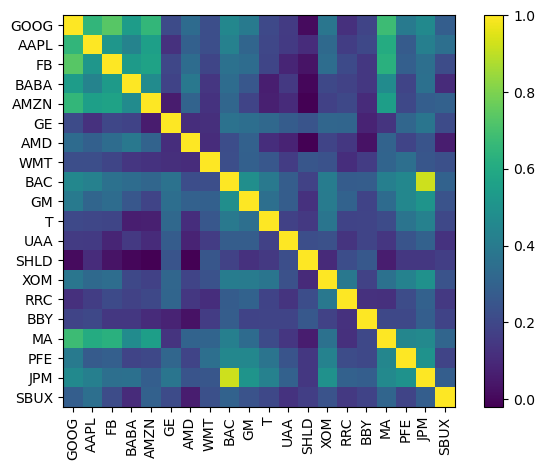

In [3]:
df = pd.read_csv("data/stock_prices.csv", parse_dates=True, index_col="date")
past_df, future_df = df.iloc[:-250], df.iloc[-250:]
future_cov = risk_models.sample_cov(future_df)

sample_cov = risk_models.sample_cov(past_df)
plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

In [4]:
past_df.tail()

,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,GM,T,UAA,SHLD,XOM,RRC,BBY,MA,PFE,JPM,SBUX
date,,,,,,,,,,,,,,,,,,,,
2017-04-06,827.880005,141.422760,141.169998,108.040001,898.280029,28.944965,13.27,69.726280,22.882135,32.807003,38.515488,20.270000,11.65,79.880356,29.765078,46.864395,111.716217,32.848938,84.634773,56.812420
2017-04-07,824.669983,141.107742,140.779999,108.989998,894.880005,29.002987,13.52,71.161209,22.783758,32.374828,38.506001,19.860001,11.34,79.639778,29.337019,47.088997,111.527428,32.839302,84.341171,56.910507
2017-04-10,824.729980,140.940399,141.039993,111.699997,907.039978,29.022331,13.10,71.317398,22.646034,32.624531,38.306786,19.730000,11.92,79.995827,29.745169,47.411259,111.606918,32.781528,84.047569,56.841843
2017-04-11,823.349976,139.424393,139.919998,110.440002,902.359985,29.051342,13.10,71.678574,22.547657,32.576508,38.240376,19.420000,13.24,79.716759,29.267334,47.508911,111.398247,32.675587,83.900772,56.773186
2017-04-12,824.320007,139.591721,139.580002,110.629997,896.229980,28.790228,12.76,71.688339,22.282043,32.595718,38.477547,19.280001,13.35,79.841858,28.411215,47.225712,110.762321,32.665962,83.577812,56.478920


We can see that visually, the sample covariance does not capture some of the new features of the covariance matrix, for example the highly correlated group of FAANG stocks. We may be able to improve this by using an exponentially-weighted covariance matrix, which gives more weight to recent data. We can also look at how each model predicts future variance.

stronger in second graph above

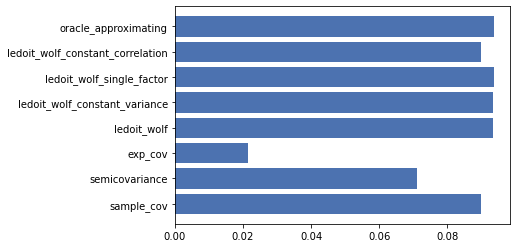

In [3]:
future_variance = np.diag(future_cov)
mean_abs_errors = []

risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

for method in risk_methods:
    S = risk_models.risk_matrix(df, method=method)
    variance = np.diag(S)
    mean_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, risk_methods)
plt.show()

We can see that the exponential covariance matrix is a much better estimator of future variance compared to the other models. Its mean absolute error is 2%, which is actually pretty good. Let's visually compare the exponential cov matrix to the realised future cov matrix:

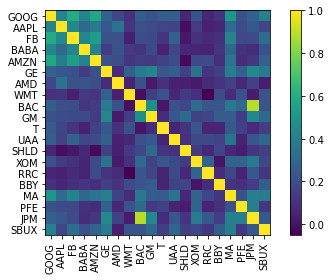

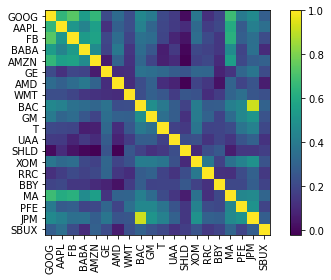

In [4]:
exp_cov = risk_models.exp_cov(past_df)
plotting.plot_covariance(exp_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

## Returns

What about returns? Will the exponentially-weighted returns similarly be the best performer?

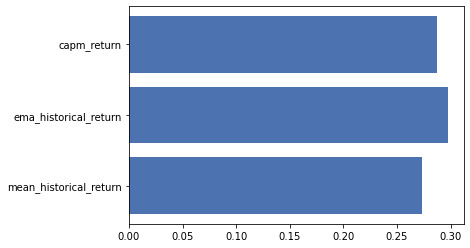

In [5]:
future_rets = expected_returns.mean_historical_return(future_df)
mean_abs_errors = []
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    "capm_return",
    ]

for method in return_methods:
    mu = expected_returns.return_model(past_df, method=method)
    mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.show()

In [6]:
print(mean_abs_errors)

[0.2732675295106071, 0.29740354389638524, 0.28701847303235856]


The exponential moving average is marginally better than the others, but the improvement is almost unnoticeable. We also note that the mean absolute deviations are above 25%, meaning that if your expected annual returns are 10%, on average the realised annual return could be anywhere from a 15% loss to a 35% gain. This is a massive range, and gives some context to the advice in the docs suggesting that you optimize without providing an estimate of returns.

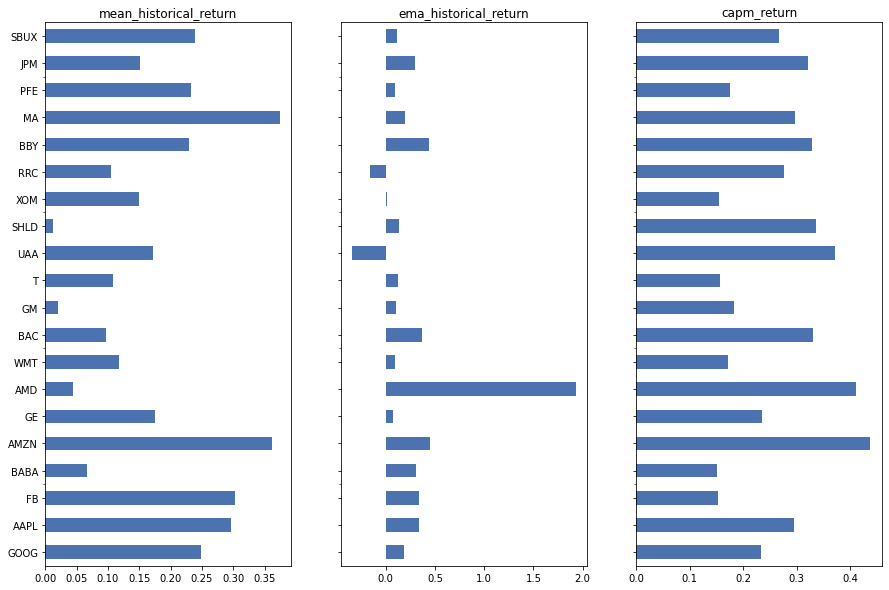

In [7]:
fig, axs = plt.subplots( 1, len(return_methods),sharey=True, figsize=(15,10))

for i, method in enumerate(return_methods):
    mu = expected_returns.return_model(past_df, method=method)
    axs[i].set_title(method)
    mu.plot.barh(ax=axs[i])

The good news is that we see a good degree of agreement (apart from the `ema` method).